This notebook implements CNN Transfer Learning to classify faces with mask or not.

Transfer Learning is a powerful way to leverage the performance of large pre-trained CNN models.
With Transfer Learning the final dense Layers of the pre-trained CNNs used for image classification
are replaced by (a) new dense layer(s) where the new final layer implements a Softmax activation over
the new classes to predict. This way the extremely strong feature extractors of the pre-trained CNNs
can be used to predict the new classes. General consensus exists that image features used to classify
cars, airplanes, bicycles, etc. are also useful to e.g. classify between dog breeds.

Training the CNN with the new dense layers should be executed in 2 phases:

- Phase 1: Only train the new dense layers. This way the output of the CNN convolutions remains stable
to allows the dense layers learn to classify the extracted features to classes. The original trained
CNN layers will remain “frozen”.
- Phase 2: In this phase one additionally “fine-tunes” either the full CNN or selected layers only
to further increase predictive accuracy of the network. A lower learning-rate is used to prevent too
drastic changes to the feature extractors.


**Notes**

1. As a single epoch of transfer learning already achieves 100% accuracy on test, Phase 2 is omitted.
2. The dataset includes only frontal face shots. 100% test accuracy is achieved even without image data augmentation.

The **Tuner** class is taken from my github repo:  
https://github.com/mikeleske/cnn

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

---

# Load images

Load the images in train, validation and test datasets. 
All classes only include only frontal face shots. 100% test accuracy is achieved even without image data augmentation.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=32
img_height=224
img_width=224

data_gen_args_train = dict(
        rescale=1./255,
        rotation_range=30,
        zoom_range=0.3,
        shear_range=0.3,
        width_shift_range=0.3, 
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
    )

data_gen_args_base = dict(
        rescale=1./255
    )


train_dir = '/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Train'
val_dir = '/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation'
test_dir = '/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Test'


train_image_generator = ImageDataGenerator(**data_gen_args_base) # Generator for our training data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary')

val_image_generator = ImageDataGenerator(**data_gen_args_base) # Generator for our training data
val_data_gen = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary')

test_image_generator = ImageDataGenerator(**data_gen_args_base) # Generator for our training data
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary')

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Show sample images

In [4]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

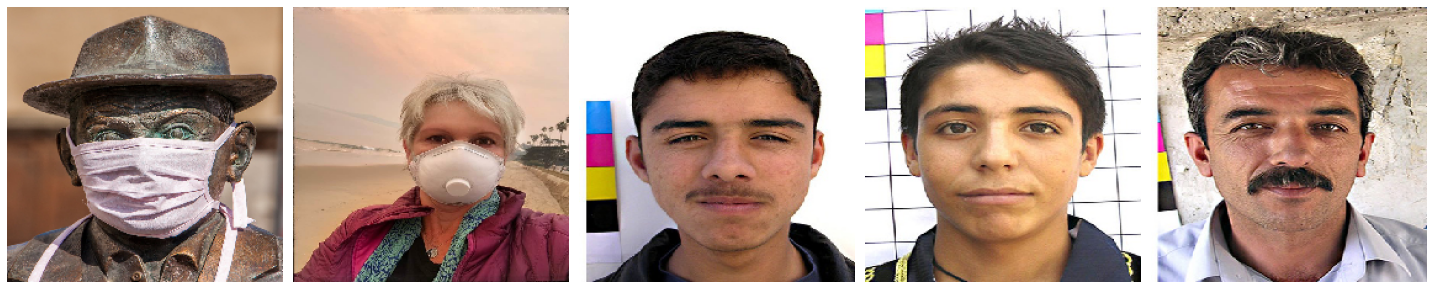

In [5]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

# Fine-Tune

In [6]:
class Tuner(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
        self.input_shape = (224, 224, 3)

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.hidden_layers = hidden_layers
        
        self.classes = classes

        self.train_ds = data[0]
        self.val_ds   = data[1]
        self.test_ds  = data[2]

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.predictions = None
        self.score = None

        self.best_weights = None

    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None

        if self.base_arch == 'VGG16':
            nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'InceptionV3':
            nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'Xception':
            nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet121':
            nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet201':
            nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'ResNet152V2':
            nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNet':
            nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNetV2':
            nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)

        return nn
    
    def run(self):
        '''
        Main driver for Learner object
        '''
        self.fine_tune()


    def build(self):
        '''
        Build model. Add Dense layer to topless base CNN.
        '''

        model = tf.keras.models.Sequential()
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.4))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        
        print (model.summary())

        return model
    
    def load_weights(self, name):
        '''
        Load the best checkpointed weights.
        '''
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

             
    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        history = self.model.fit(
            self.train_ds,
            epochs=self.EPOCHS,
            validation_data=self.val_ds,
            callbacks=[checkpoint])

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()

        # Plot only meaningful, when more than 1 epochs
        if self.EPOCHS > 1:
            self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')
        
    def predict(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.test_ds, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.test_ds)
        print('Done')

    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()

In [10]:
NET = 'MobileNetV2'
HIDDEN_LAYERS = [512, 128]
CLASSES = 2
EPOCHS = 1
BATCH_SIZE = 32

data = (train_data_gen, val_data_gen, test_data_gen)

model = Tuner(data, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
model.run()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               32113152  
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              